In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random




In [65]:
def load_labels(base_dir, num_samples=10):
    txt_data = {}
    label_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".txt"):
                label_files.append(os.path.join(root, file))
    
    selected_label_files = random.sample(label_files, min(num_samples, len(label_files)))
    
    for file_path in selected_label_files:
        try:
            with open(file_path, 'r') as f:
                txt_data[file_path] = f.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(txt_data)} TXT files from {base_dir}")
    return txt_data

def load_images(base_dir, num_samples=10):
    images = []
    filenames = []
    image_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))
    
    selected_image_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for file_path in selected_image_files:
        try:
            image = Image.open(file_path).resize((224, 224)).convert('RGB')
            images.append(np.array(image))
            filenames.append(file_path)
        except UnidentifiedImageError as e:
            print(f"Error loading image {file_path}: {e}")
    
    print(f"Loaded {len(images)} images from {base_dir}")
    return np.array(images), filenames


In [66]:
BASE = "Database_Realtime"
IMU = os.path.join(BASE, "IMU")
VISION = os.path.join(BASE, "Vision/Webcam")

print("Loading Labels...")
txt_files = load_labels(IMU, num_samples=10)

print("Loading Images...")
images, image_paths = load_images(VISION, num_samples=10)

print("Image shape:", images.shape)
print("Labels:", len(txt_files))


Loading Labels...
Loaded 10 TXT files from Database_Realtime\IMU
Loading Images...
Loaded 10 images from Database_Realtime\Vision/Webcam
Image shape: (10, 224, 224, 3)
Labels: 10


In [67]:
def parse_labels(txt_data):
    labels = []
    for file_path, data in txt_data.items():
        lines = data.splitlines()
        for line in lines:
            values = line.split()
            if len(values) >= 4:
                pose = int(values[0]) 
                depth = float(values[1])  
                pitch = float(values[2])  
                roll = float(values[3])  
                labels.append([pose, depth, pitch, roll])
    return np.array(labels)

y_labels = parse_labels(txt_files)
print("Parsed Labels Shape:", y_labels.shape)


Parsed Labels Shape: (1730, 4)


In [68]:


X_images = images / 255.0  

y_pose = y_labels[:X_images.shape[0], 0]  
depth_labels = y_labels[:X_images.shape[0], 1]  

y_labels = np.stack((y_pose, depth_labels), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)




Training set shape: (6, 224, 224, 3)
Validation set shape: (2, 224, 224, 3)
Test set shape: (2, 224, 224, 3)


In [69]:
def create_lenet_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet_classification(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step - accuracy: 0.0000e+00 - loss: 2.3117 - val_accuracy: 0.0000e+00 - val_loss: 4.1243
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1667 - loss: 1.9954 - val_accuracy: 0.0000e+00 - val_loss: 4.4281
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1667 - loss: 1.7748 - val_accuracy: 0.0000e+00 - val_loss: 4.6166
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5000 - loss: 1.5519 - val_accuracy: 0.0000e+00 - val_loss: 5.3396
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5000 - loss: 1.2647 - val_accuracy: 0.0000e+00 - val_loss: 6.8250
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6667 - loss: 1.0166 - val_accuracy: 0.0000e+00 - val_loss: 8.7983
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6667 - loss: 0.8373 - val_accuracy: 0.0000e+00 - val_loss: 10.6641
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8333 - loss: 0.6476 - val_accuracy: 0.0

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

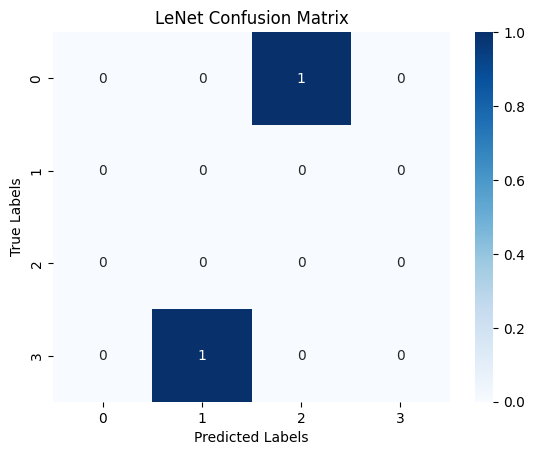

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 3.8413 - val_accuracy: 0.0000e+00 - val_loss: 4.2056
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.1667 - loss: 96.9741 - val_accuracy: 0.0000e+00 - val_loss: 7.2310
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5000 - loss: 240.9135 - val_accuracy: 0.0000e+00 - val_loss: 8.1085
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.1667 - loss: 139.8149 - val_accuracy: 0.0000e+00 - val_loss: 7.1661
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8333 - loss: 21.6581 - val_accuracy: 0.0000e+00 - val_loss: 7.6809
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5000 - loss: 100.3387 - val_accuracy: 0.0000e+00 - val_loss: 7.6888
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5000 - loss: 75.2647 - val_accuracy: 0.0000e+00 - val_loss: 8.2865
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6667 - loss: 31.9373

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

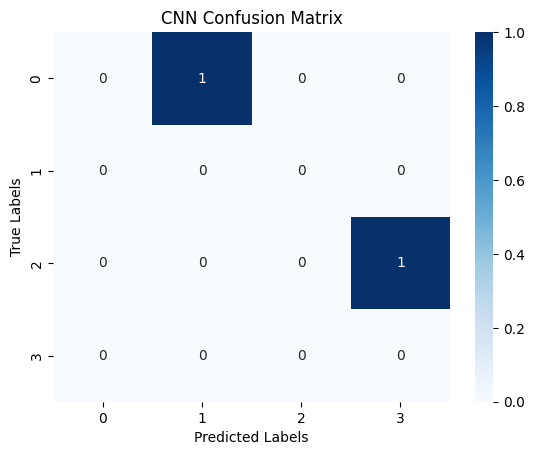

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.1667 - loss: 3.7561 - val_accuracy: 0.0000e+00 - val_loss: 2.3174
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.1667 - loss: 5.6055 - val_accuracy: 0.0000e+00 - val_loss: 2.3457
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - accuracy: 0.3333 - loss: 2.5378 - val_accuracy: 0.0000e+00 - val_loss: 2.3706
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.3333 - loss: 3.6091 - val_accuracy: 0.0000e+00 - val_loss: 2.4076
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - accuracy: 0.5000 - loss: 3.0727 - val_accuracy: 0.0000e+00 - val_loss: 2.4468
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.5000 - loss: 2.1232 - val_accuracy: 0.0000e+00 - val_loss: 2.4913
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.3333 - loss: 3.9266 - val_accuracy: 0.0000e+00 - val_loss: 2.5246
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 0.6667 - loss: 1.4443 - val_a

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

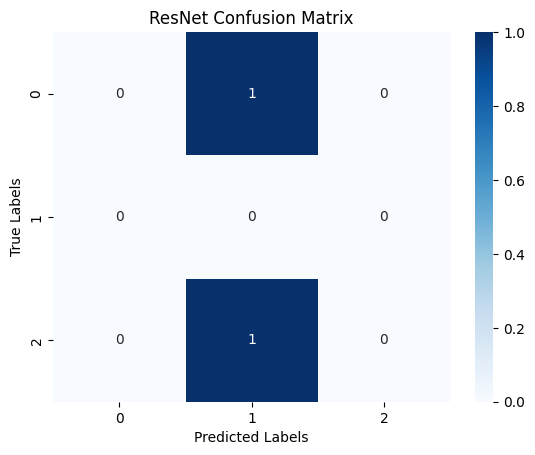

In [ ]:

all_labels = np.concatenate((y_train[:, 0], y_val[:, 0], y_test[:, 0]), axis=0)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels.astype('int'))

y_train_classes = label_encoder.transform(y_train[:, 0].astype('int'))
y_val_classes = label_encoder.transform(y_val[:, 0].astype('int'))
y_test_classes = label_encoder.transform(y_test[:, 0].astype('int'))

def train_and_evaluate_classification(model, model_name):
    history = model.fit(X_train, y_train_classes, epochs=10, batch_size=16,
                        validation_data=(X_val, y_val_classes), verbose=1)
    y_pred = model.predict(X_test).argmax(axis=1)
    

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_classes, y_pred))
    cm = confusion_matrix(y_test_classes, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    return history

lenet_model = create_lenet_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(lenet_model, "LeNet")

cnn_model = create_cnn_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(cnn_model, "CNN")

resnet_model_class = create_resnet_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(resnet_model_class, "ResNet")


Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (2, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


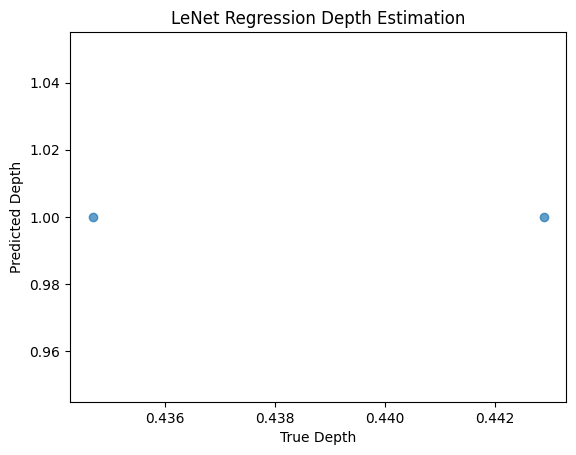

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (2, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


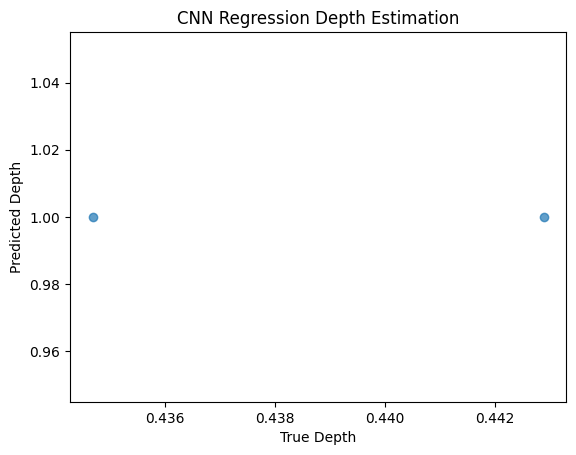

Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (2, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE for ResNet Regression: 0.56


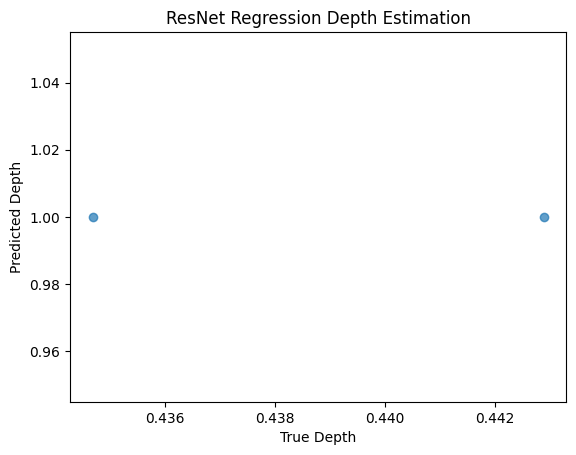

In [71]:
def create_regression_model(input_shape, model_name="cnn"):
    if model_name == "lenet":
        return create_lenet_classification(input_shape, 1)
    elif model_name == "cnn":
        return create_cnn_classification(input_shape, 1)
    elif model_name == "resnet":
        return create_resnet_classification(input_shape, 1)
    else:
        raise ValueError("Invalid model_name")

def train_and_evaluate_regression(model, model_name):
    history = model.fit(X_train, y_train[:, 1], epochs=10, batch_size=16,
                        validation_data=(X_val, y_val[:, 1]), verbose=1)
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test[:, 1], y_pred))
    print(f"RMSE for {model_name}: {rmse:.2f}")
    

    plt.scatter(y_test[:, 1], y_pred, alpha=0.7)
    plt.xlabel("True Depth")
    plt.ylabel("Predicted Depth")
    plt.title(f"{model_name} Depth Estimation")
    plt.show()
    return history

lenet_reg = create_regression_model(X_train.shape[1:], "lenet")
train_and_evaluate_regression(lenet_reg, "LeNet Regression")

cnn_reg = create_regression_model(X_train.shape[1:], "cnn")
train_and_evaluate_regression(cnn_reg, "CNN Regression")

resnet_reg = create_regression_model(X_train.shape[1:], "resnet")
train_and_evaluate_regression(resnet_reg, "ResNet Regression")
